In [9]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

maxDSnumbers = 7000
sizeFixed = (90,90)
dsImages = "/home/chtseng/train-opencvCascade/body1"
dsRetrain = "/home/chtseng/train-opencvCascade/keras/body_retrain"
epoch = 10
batchSize = 64
#testPath = "/home/chtseng/train-opencvCascade/keras/datasets/head_test"

In [10]:
import os
from keras.models import Sequential # Initialise our neural network model as a sequential network
from keras.layers import Conv2D # Convolution operation
from keras.layers import MaxPooling2D # Maxpooling function
from keras.layers import Flatten # Converting 2D arrays into a 1D linear vector.
from keras.layers import Dense # Perform the full connection of the neural network
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import display
from PIL import Image
import cv2
import numpy as np
from sklearn.metrics import accuracy_score
from skimage import io, transform
import matplotlib.pyplot as plt
%matplotlib inline

from keras import optimizers

In [11]:
def cnn_classifier():
    cnn = Sequential()
    cnn.add(Conv2D(32, (3,3), input_shape = (sizeFixed[0], sizeFixed[1], 3), padding='same', activation = 'relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(Conv2D(64, (3,3), padding='same', activation = 'relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(Flatten())
    cnn.add(Dense(500, activation = 'relu'))
    cnn.add(Dense(output_dim = 2, activation = 'softmax'))

    cnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    print(cnn.summary())
    return cnn

def reshaped_image(image):
    return transform.resize(image,(sizeFixed[0], sizeFixed[1], 3)) # (cols (width), rows (height)) and don't use np.resize()
   
def load_images_from_folder(dbFolder):
    train_images = []
    train_labels = []
    l = [0,0] # [False,True]
    
    Images = os.listdir(dbFolder + "/pos-images/") 
    
    i = 0
    for image in Images:
        if(i<maxDSnumbers):
            path = os.path.join(dbFolder + "/pos-images/", image)
            img = cv2.imread(path)
            train_images.append(reshaped_image(img))
            l = [0,1]
            train_labels.append(l)
            i += 1

    i = 0
    Images = os.listdir(dbFolder + "/neg-images/")    
    for image in Images:
        if(i<maxDSnumbers):
            path = os.path.join(dbFolder + "/neg-images/", image)
            img = cv2.imread(path)
            train_images.append(reshaped_image(img))
            l = [1,0]
            train_labels.append(l)
            i += 1
        
    return np.array(train_images), np.array(train_labels)
        
def train_test_split(train_data, train_labels, fraction):
    index = int(len(train_data)*fraction)
    return train_data[:index], train_labels[:index], train_data[index:], train_labels[index:]

train_data, train_labels = load_images_from_folder(dsImages)
#train_data = train_data.astype('float32') / 255.0

fraction = 0.8
train_data, train_labels, test_data, test_labels = train_test_split(train_data, train_labels, fraction)
print ("Train data size: ", len(train_data))
print ("Test data size: ", len(test_data))

cnn = cnn_classifier()

print ("Train data shape: ", train_data.shape)
print ("Test data shape: ", test_data.shape)

idx = np.random.permutation(train_data.shape[0])
cnn.fit(train_data[idx], train_labels[idx], batch_size = batchSize, epochs = epoch)

#test_data = test_data.astype('float32') / 255.0
predicted_test_labels = np.argmax(cnn.predict(test_data), axis=1)
test_labels = np.argmax(test_labels, axis=1)

print ("Actual test labels:", test_labels)
print ("Predicted test labels:", predicted_test_labels)

print ("Accuracy score:", accuracy_score(test_labels, predicted_test_labels))

Train data size:  2003
Test data size:  501
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 90, 90, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               16928500  
_________________________________________________________________
dense_4 (Dense)              (No

In [12]:
# serialize model to JSON
model_json = cnn.to_json()
with open("body_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn.save_weights("body_model.h5")
print("Saved model to disk")

Saved model to disk


In [50]:
from keras.models import model_from_json

# load json and create model
json_file = open('./body_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./body_model.h5",by_name=True)
print("Loaded model from disk")
 

Loaded model from disk


(1, 90, 90, 3)
0


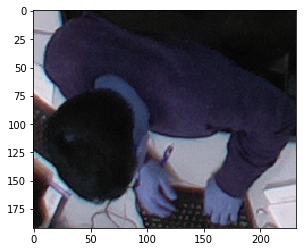

In [51]:
# evaluate loaded model on test data
loaded_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

test_image = []
img = cv2.imread("/home/chtseng/train-opencvCascade/body1/pos-images/646-3.jpg")
#img = cv2.imread("/home/chtseng/train-opencvCascade/heads/neg-images/aug_0_2101.jpg")
#img = cv2.imread("/home/chtseng/train-opencvCascade/heads/neg-images/aug_0_6636.jpg")
plt.imshow(img)
test_image.append(reshaped_image(img))
test_image = np.array(test_image)
print(test_image.shape)

#test_image = test_image.astype('float32') / 255.0
#result = loaded_model.predict(test_image)
img_class = loaded_model.predict_classes(test_image)
prediction = img_class[0]
print(prediction)
#print( np.argmax(result, axis=1) )

In [52]:
dsRetrain = "/home/chtseng/train-opencvCascade/keras/body_retrain"

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    zca_whitening=False,
    rotation_range=180,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

#Retrain
train_data, train_labels = load_images_from_folder(dsRetrain)
#train_data = train_data.astype('float32') / 255.0

fraction = 0.9
train_data, train_labels, test_data, test_labels = train_test_split(train_data, train_labels, fraction)
print ("Train data size: ", len(train_data))
print ("Test data size: ", len(test_data))


idx = np.random.permutation(train_data.shape[0])
#loaded_model.fit(train_data[idx], train_labels[idx], batch_size = batchSize, epochs = epoch)
datagen.fit(train_data)

loaded_model.fit_generator(datagen.flow(train_data,train_labels, batch_size=32),
    steps_per_epoch=round(len(train_data)/32),epochs=60, validation_data=(test_data, test_labels))


test_data = test_data.astype('float32') / 255.0
predicted_test_labels = np.argmax(loaded_model.predict(test_data), axis=1)
test_labels = np.argmax(test_labels, axis=1)

print ("Actual test labels:", test_labels)
print ("Predicted test labels:", predicted_test_labels)

print ("Accuracy score:", accuracy_score(test_labels, predicted_test_labels))

Train data size:  661
Test data size:  74
Epoch 1/60
21/21 [==============================] - 10s 491ms/step - loss: 1.4777 - acc: 0.3805 - val_loss: 0.7457 - val_acc: 0.0000e+00
Epoch 2/60
21/21 [==============================] - 10s 465ms/step - loss: 0.6866 - acc: 0.5428 - val_loss: 0.7583 - val_acc: 0.0000e+00
Epoch 3/60
21/21 [==============================] - 10s 465ms/step - loss: 0.6827 - acc: 0.5421 - val_loss: 0.7792 - val_acc: 0.0000e+00
Epoch 4/60
21/21 [==============================] - 10s 467ms/step - loss: 0.6766 - acc: 0.5428 - val_loss: 0.8286 - val_acc: 0.0000e+00
Epoch 5/60
21/21 [==============================] - 10s 463ms/step - loss: 0.6675 - acc: 0.5503 - val_loss: 0.7755 - val_acc: 0.0270
Epoch 6/60
21/21 [==============================] - 10s 462ms/step - loss: 0.6577 - acc: 0.6426 - val_loss: 0.7140 - val_acc: 0.3243
Epoch 7/60
21/21 [==============================] - 10s 467ms/step - loss: 0.6271 - acc: 0.6999 - val_loss: 0.5434 - val_acc: 0.9865
Epoch 8/60


In [46]:
# serialize model to JSON
model_json = loaded_model.to_json()
with open("body_model_retrain.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
loaded_model.save_weights("body_model_retrain.h5")
print("Saved model to disk")

Saved model to disk
